In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
from epsampling import data_processing

### <font color=blue> Load dataset.

In [2]:
df = data_processing.load_modeling_df(timestamp='20241108-123515')
df

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,HU_x15,HU_UIS01D,HU_UIS01A,HU_UIS02,HU_UIS0304,HU_UIS0509,HU_UIS1019,HU_UIS2049,HU_UIS50P,HU_UISOTHER
0,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,...,0.365062,-0.227664,0.659506,0.164682,1.084194,1.257973,0.809439,1.264785,0.142583,-0.891177
1,20200912,37,37001,169185,10367022,0.016320,176.0,160.0,48.0,2.0,...,0.365062,-0.227664,0.659506,0.164682,1.084194,1.257973,0.809439,1.264785,0.142583,-0.891177
2,20200919,37,37001,169185,10367022,0.016320,157.0,187.0,48.0,0.0,...,0.365062,-0.227664,0.659506,0.164682,1.084194,1.257973,0.809439,1.264785,0.142583,-0.891177
3,20200926,37,37001,169185,10367022,0.016320,171.0,198.0,54.0,6.0,...,0.365062,-0.227664,0.659506,0.164682,1.084194,1.257973,0.809439,1.264785,0.142583,-0.891177
4,20201003,37,37001,169185,10367022,0.016320,171.0,189.0,56.0,2.0,...,0.365062,-0.227664,0.659506,0.164682,1.084194,1.257973,0.809439,1.264785,0.142583,-0.891177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,20220409,37,37199,18357,10367022,0.001771,55.0,43.0,51.0,0.0,...,-0.500365,0.639595,-0.628558,-0.594742,0.811392,-0.516422,-0.452744,-0.308092,-0.660873,0.018939
8108,20220416,37,37199,18357,10367022,0.001771,41.0,76.0,51.0,0.0,...,-0.500365,0.639595,-0.628558,-0.594742,0.811392,-0.516422,-0.452744,-0.308092,-0.660873,0.018939
8109,20220423,37,37199,18357,10367022,0.001771,60.0,29.0,51.0,0.0,...,-0.500365,0.639595,-0.628558,-0.594742,0.811392,-0.516422,-0.452744,-0.308092,-0.660873,0.018939
8110,20220430,37,37199,18357,10367022,0.001771,33.0,42.0,51.0,0.0,...,-0.500365,0.639595,-0.628558,-0.594742,0.811392,-0.516422,-0.452744,-0.308092,-0.660873,0.018939


### <font color=blue> Target variable exploration.

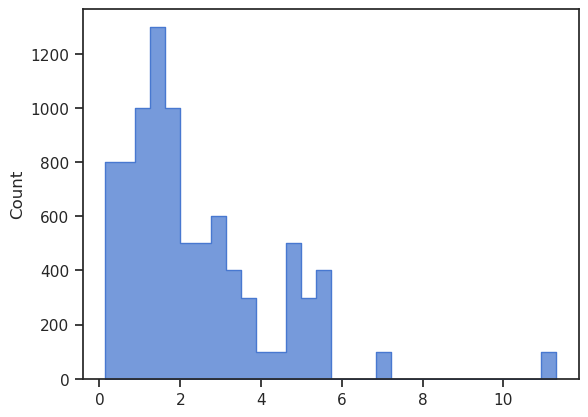

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 

sns.histplot(df.True_state_inc_deaths_x.values, bins=30, kde=False, element='step')
# sns.kdeplot(df.True_state_inc_deaths_x.values)
plt.show()

In [6]:
df.True_county_inc_deaths.describe()

count    8112.000000
mean        2.509492
std         4.829165
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        88.000000
Name: True_county_inc_deaths, dtype: float64

### <font color=blue> How does training set size affect performance?

_Choose base "predictive" attributes_

In [9]:
%precision %.2f
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True) # don't use scientific notation

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklego.meta import ZeroInflatedRegressor
from sklearn.svm import SVC

random.seed(666)

from tqdm.notebook import tqdm

def get_train_test_res_dfs(which_target_col,  
                           num_weeks_in_chunk, base_pred_cols, algs=['LinReg','ZIR']):
    # ## Random split
    # df_train, df_test = train_test_split(df, test_size=0.1, random_state=666, shuffle=True)
    ## Temporal split
    chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
    # idx = random.choice(range(len(chunks)))
    idx = 5
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)

    training_fracs = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.]

    list_test_dfs = []
    list_train_dfs = []

    for i,s in tqdm(enumerate(training_fracs), total=len(training_fracs)):

        dff_train = df_train.sample(frac=s,random_state=666)

        dff_test = df_test.copy()
        dff_train_for_eval = df_train.copy()

        feats =  base_pred_cols + [x for x in df_acs.columns] 
        X_train = dff_train[feats]
        y_train = dff_train[which_target_col]
        X_test = dff_test[feats]
        
        for alg in algs:
            
            pred_col = f'{alg} <{which_target_col}>'
        
            if alg=='LinReg':
                reg = linear_model.LinearRegression().fit(X_train, y_train)
            elif alg=='PoisReg':
                reg = linear_model.PoissonRegressor().fit(X_train, y_train)
            elif alg=='ZIR':
                reg = ZeroInflatedRegressor(
                    classifier=SVC(),
                    regressor=linear_model.LinearRegression()).fit(X_train, y_train)

            dff_test[f'{pred_col}'] = reg.predict(X_test)
            dff_train_for_eval[f'{pred_col}'] = reg.predict(dff_train_for_eval[feats])

        list_test_dfs.append(dff_test)
        list_train_dfs.append(dff_train_for_eval)
        
    return list_test_dfs, list_train_dfs, training_fracs, df_train, df_test


  0%|          | 0/8 [00:00<?, ?it/s]

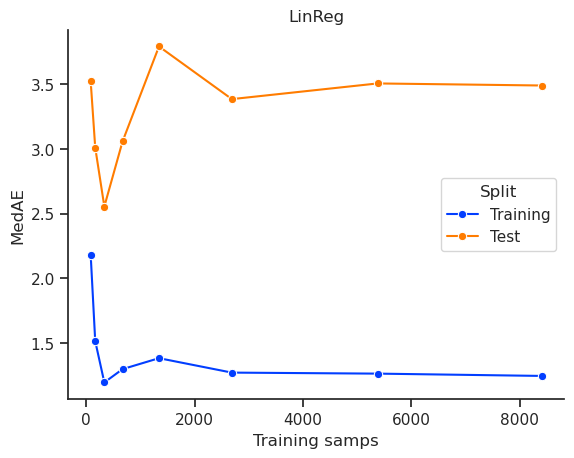

,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training samps,Split
0,4.40,2.18,-1.16,46.35,1.80,1.84,84.00,Training
1,2.62,1.52,0.11,19.19,1.07,1.09,168.00,Training
2,2.12,1.20,0.28,15.51,0.87,0.88,336.00,Training
3,2.13,1.30,0.35,13.92,0.87,0.89,672.00,Training
4,2.18,1.38,0.37,13.60,0.89,0.91,1344.00,Training
5,2.05,1.27,0.40,12.85,0.84,0.85,2688.00,Training
6,2.02,1.26,0.41,12.61,0.83,0.84,5376.00,Training
7,2.01,1.25,0.42,12.54,0.82,0.84,8400.00,Training


,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training samps,Split
8,5.71,3.52,0.00,69.35,1.03,1.03,84.00,Test
9,4.62,3.01,0.21,54.96,0.83,0.83,168.00,Test
10,4.28,2.56,0.21,55.28,0.77,0.77,336.00,Test
11,4.29,3.06,0.31,48.27,0.77,0.77,672.00,Test
12,4.57,3.79,0.35,45.51,0.82,0.82,1344.00,Test
13,4.36,3.39,0.36,44.83,0.78,0.78,2688.00,Test
14,4.41,3.51,0.35,45.03,0.79,0.79,5376.00,Test
15,4.38,3.49,0.36,44.71,0.79,0.79,8400.00,Test


  0%|          | 0/8 [00:00<?, ?it/s]

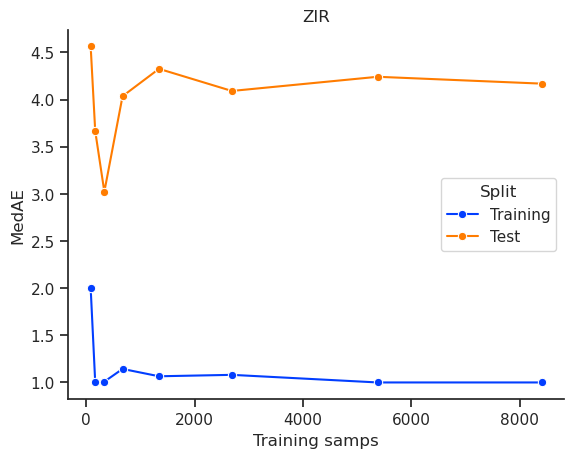

,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training samps,Split
0,3.60,2.00,-0.75,37.62,1.47,1.50,84.00,Training
1,2.24,1.00,0.19,17.49,0.92,0.93,168.00,Training
2,2.34,1.01,0.09,19.52,0.96,0.98,336.00,Training
3,2.23,1.14,0.26,15.99,0.91,0.93,672.00,Training
4,2.16,1.07,0.32,14.66,0.88,0.90,1344.00,Training
5,2.06,1.08,0.36,13.79,0.84,0.86,2688.00,Training
6,1.99,1.00,0.39,13.06,0.81,0.83,5376.00,Training
7,1.98,1.00,0.40,12.95,0.81,0.83,8400.00,Training


,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training samps,Split
8,6.53,4.56,-0.16,80.76,1.17,1.18,84.00,Test
9,4.84,3.66,0.23,53.69,0.87,0.87,168.00,Test
10,4.87,3.02,0.13,60.76,0.88,0.88,336.00,Test
11,4.86,4.03,0.28,50.33,0.87,0.87,672.00,Test
12,5.10,4.33,0.30,49.02,0.92,0.92,1344.00,Test
13,4.89,4.09,0.31,48.16,0.88,0.88,2688.00,Test
14,4.88,4.24,0.33,46.88,0.88,0.88,5376.00,Test
15,4.86,4.17,0.33,46.53,0.88,0.88,8400.00,Test


In [22]:
targ = 'True_county_inc_deaths'
bpd = 'True_state_inc_deaths'
# for targ,bpd in [ ['True_county_inc_deaths','True_state_inc_deaths'] ]:
#                  ['True_county_inc_deaths_x','True_state_inc_deaths_x']]:

for alg in ['LinReg','ZIR']:
                
# for which_target_col,bpd in [ ['True_county_inc_deaths','True_state_inc_deaths'] ]:
    list_test_dfs, list_train_dfs, training_fracs, df_train, df_test = get_train_test_res_dfs(which_target_col=which_target_col, 
                                     num_weeks_in_chunk=4, base_pred_cols=[bpd], algs=[alg]) # ,'ZIR'])
    
    pred_col = f'{alg} <{which_target_col}>'
    
    training_fracs = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.]

#     display(list_test_dfs[0])
    
    ## GET PERFORMANCE !
    from epsampling.modeling import get_metrics_ser

    metrics_sers = []
    for l,split in [[list_train_dfs,'Training'], [list_test_dfs,'Test']]:

        for i,dff in enumerate(l):
            ser = get_metrics_ser(dff, 
                                  target_col=which_target_col, 
                                  pred_col=pred_col)
            ser['Training frac'] = training_fracs[i]
            ser['Training samps'] = training_fracs[i] * len(df_train)
            ser['Split'] = split
            ## drop model attr bc only have one
            ser.pop('Model')
            metrics_sers.append(ser)

    df_metrics = pd.DataFrame(metrics_sers)

    ## PLOT !

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=1, style='ticks', palette='bright') 

    sns.lineplot(df_metrics, y='MedAE', x='Training samps', marker='o',hue='Split')
    sns.despine()
    plt.title(f'{alg}')
    
    plt.show()
    
    
    df_metrics.drop('Training frac',axis=1,inplace=True)
    display(
        df_metrics[df_metrics.Split=='Training'],
            df_metrics[df_metrics.Split=='Test'])

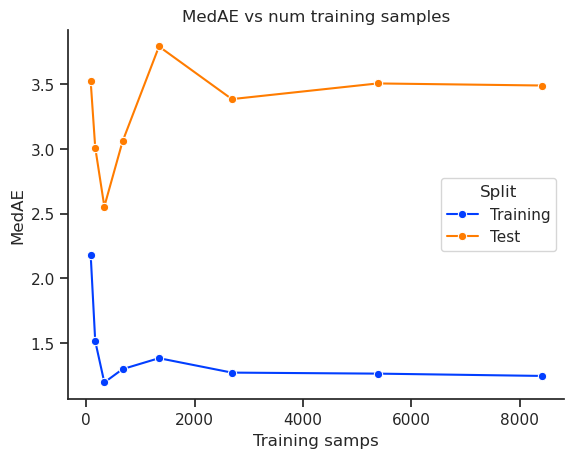

In [19]:
algs = ['LinReg','LinReg']
targ_cols = ['True_county_inc_deaths','True_county_inc_deaths_x']

for alg, targ_col in zip (algs, targ_cols):
    pred_col = f'{alg} <{targ_col}>'

for targ,pred in [ ['True_county_inc_deaths',] ]:
    
which_target_col = targ
pred_col = 'LinReg <True_county_inc_deaths>'

training_fracs = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.]

    
## GET PERFORMANCE !
from epsampling.modeling import get_metrics_ser

metrics_sers = []
for l,split in [[list_train_dfs,'Training'], [list_test_dfs,'Test']]:
    
    for i,dff in enumerate(l):
        ser = get_metrics_ser(dff, 
                              target_col=which_target_col, 
                              pred_col=pred_col)
        ser['Training frac'] = training_fracs[i]
        ser['Training samps'] = training_fracs[i] * len(df_train)
        ser['Split'] = split
        ## drop model attr bc only have one
        ser.pop('Model')
        metrics_sers.append(ser)

df_metrics = pd.DataFrame(metrics_sers)

## PLOT !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 
    
sns.lineplot(df_metrics, y='MedAE', x='Training samps', marker='o',hue='Split')
sns.despine()
plt.title(f'MedAE vs num training samples')
plt.show()

In [18]:
# display(df_metrics[df_metrics.Split=='Training'],
#         df_metrics[df_metrics.Split=='Test'])

In [20]:
display(df_metrics[df_metrics.Split=='Training'],
        df_metrics[df_metrics.Split=='Test'])

,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
0,4.40,2.18,-1.16,46.35,1.80,1.84,0.01,84.00,Training
1,2.62,1.52,0.11,19.19,1.07,1.09,0.02,168.00,Training
2,2.12,1.20,0.28,15.51,0.87,0.88,0.04,336.00,Training
3,2.13,1.30,0.35,13.92,0.87,0.89,0.08,672.00,Training
4,2.18,1.38,0.37,13.60,0.89,0.91,0.16,1344.00,Training
5,2.05,1.27,0.40,12.85,0.84,0.85,0.32,2688.00,Training
6,2.02,1.26,0.41,12.61,0.83,0.84,0.64,5376.00,Training
7,2.01,1.25,0.42,12.54,0.82,0.84,1.00,8400.00,Training


,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
8,5.71,3.52,0.00,69.35,1.03,1.03,0.01,84.00,Test
9,4.62,3.01,0.21,54.96,0.83,0.83,0.02,168.00,Test
10,4.28,2.56,0.21,55.28,0.77,0.77,0.04,336.00,Test
11,4.29,3.06,0.31,48.27,0.77,0.77,0.08,672.00,Test
12,4.57,3.79,0.35,45.51,0.82,0.82,0.16,1344.00,Test
13,4.36,3.39,0.36,44.83,0.78,0.78,0.32,2688.00,Test
14,4.41,3.51,0.35,45.03,0.79,0.79,0.64,5376.00,Test
15,4.38,3.49,0.36,44.71,0.79,0.79,1.00,8400.00,Test


### <font color=blue> Train CS splits and look at per-county performance.

In [ ]:
target_col = 'True_county_inc_deaths'

# # # # # # # # # # # # # # # # # # # #
num_weeks_in_chunk = 4
num_runs = 20
alg = 'ZIR'

chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
idc = random.sample(range(len(chunks)), num_runs)

test_dfs = []
models = {}

for i,idx in tqdm(enumerate(idc), total=len(idc)):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)
    
#     display(df_test.head())
        
    df_test[f'Run'] = i

#     for main_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:
    for main_pred_col in ['Naive_true_deaths','Naive_proj_deaths']:
        
        feats =  [main_pred_col] + BASE_PRED_COLS + [x for x in df_acs.columns] 
        X_train = df_train[feats]
        y_train = df_train[target_col]

        X_test = df_test[feats]
#         display(X_test[:5])
#         print('hi')

        reg = LinearRegression().fit(X_train, y_train)

        df_test[f'{alg}_({main_pred_col})'] = reg.predict(X_test)
        

    test_dfs.append(df_test)
    models[i] = reg
    
df_res = pd.concat(test_dfs)
df_res.drop(df_acs.columns,axis=1,inplace=True)

print(f'Training set size: {len(X_train)}\nTest set size: {len(X_test)}')